In [15]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Define the base path for the project directory in Google Drive
base_path = '/content/drive/mydrive/oil_spill_detection'

In [17]:
!pip install segmentation-models-pytorch albumentations -q

In [18]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm

DATA_ROOT = "/content/drive/MyDrive/oilspilldataset"
TRAIN_IMG = os.path.join(DATA_ROOT, "trainimages")
TRAIN_MASK = os.path.join(DATA_ROOT, "trainmasks")
VAL_IMG = os.path.join(DATA_ROOT, "valimages")
VAL_MASK = os.path.join(DATA_ROOT, "valmasks")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMGSIZE = (256, 256)
BATCH_SIZE = 8


In [19]:
train_aug = A.Compose([
    A.Resize(IMGSIZE[0], IMGSIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.12, scale_limit=0.15, rotate_limit=20, p=0.7),
    A.RandomBrightnessContrast(p=0.4),
    A.OneOf([
        A.GaussianBlur(p=1.0),
        A.MotionBlur(p=1.0),
        A.MedianBlur(blur_limit=3, p=1.0)
    ], p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
val_aug = A.Compose([
    A.Resize(IMGSIZE[0], IMGSIZE[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [20]:
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import cv2  # Import cv2

# Base path matching your Google Drive folder name exactly
base_path = '/content/drive/MyDrive/oil_spill_dataset'

# ✅ Correct folder names
TRAIN_IMG = os.path.join(base_path, 'train/images')
TRAIN_MASK = os.path.join(base_path, 'train/masks')
VAL_IMG = os.path.join(base_path, 'val/images')
VAL_MASK = os.path.join(base_path, 'val/masks')

class OilSpillDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.imgs = sorted([os.path.join(img_dir, fname) for fname in os.listdir(img_dir)])
        self.masks = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
        self.transforms = transforms

        if len(self.imgs) != len(self.masks):
            raise ValueError(f"Number of images ({len(self.imgs)}) and masks ({len(self.masks)}) do not match in {img_dir} and {mask_dir}")

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(self.imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        mask = (mask > 127).astype(np.float32)

        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        if mask.ndim == 2:
            mask = mask.unsqueeze(0)
        elif mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask.permute(2, 0, 1)

        return img, mask

# Ensure train_aug and val_aug are defined earlier
BATCH_SIZE = 8
trainset = OilSpillDataset(TRAIN_IMG, TRAIN_MASK, train_aug)
valset = OilSpillDataset(VAL_IMG, VAL_MASK, val_aug)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [21]:
import os

img_dir = '/content/drive/MyDrive/oil_spill_dataset/val/images'
mask_dir = '/content/drive/MyDrive/oil_spill_dataset/val/masks'

imgs = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.png') or f.endswith('.jpg')])
masks = sorted([os.path.splitext(f)[0] for f in os.listdir(mask_dir) if f.endswith('.png') or f.endswith('.jpg')])

missing_masks = [f for f in imgs if f not in masks]
missing_imgs = [f for f in masks if f not in imgs]

print("Images with missing masks:", missing_masks)
print("Masks with missing images:", missing_imgs)
print(f"\nTotal images: {len(imgs)}, Total masks: {len(masks)}")


Images with missing masks: []
Masks with missing images: []

Total images: 203, Total masks: 203


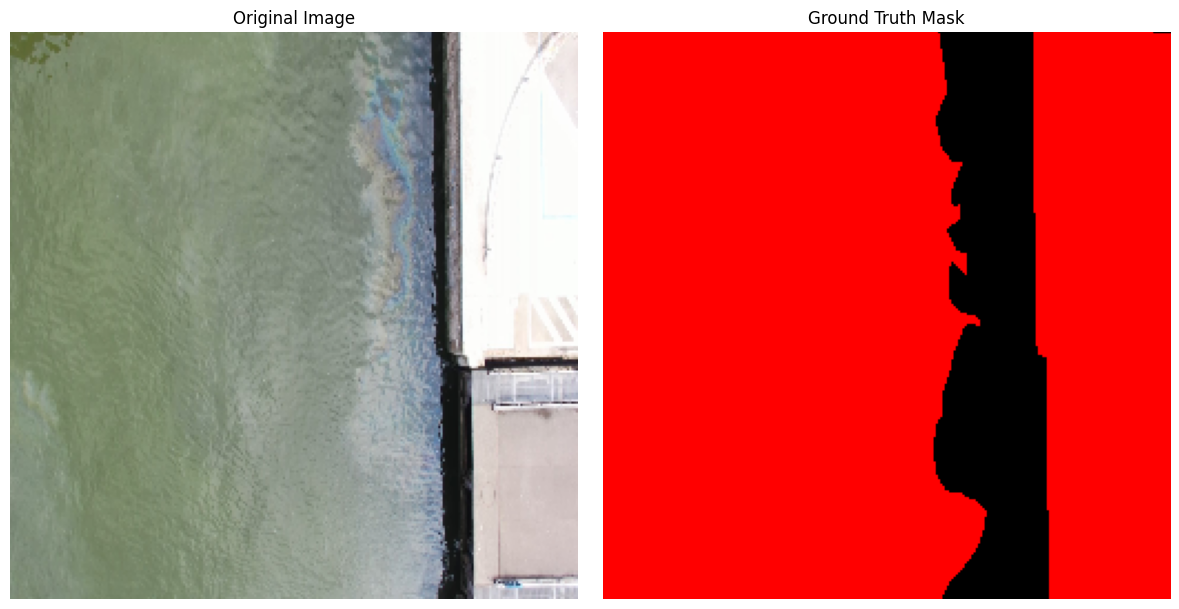

In [22]:
def color_mask(mask):
    # mask: HxW, 1 or 0
    h, w = mask.shape
    cmask = np.zeros((h, w, 3), dtype=np.uint8)
    cmask[mask==1] = [255, 0, 0] # Oil spill: red
    return cmask

# Get a batch from the validation loader
imgs, masks = next(iter(val_loader))
img = imgs[0].permute(1,2,0).cpu().numpy()
mask = masks[0][0].cpu().numpy()

# De-normalize the image for display
img_display = (img * [0.229,0.224,0.225] + [0.485,0.456,0.406]).clip(0,1)

# Create color masks for visualization
ground_truth_cmask = color_mask(mask)

# Plotting
plt.figure(figsize=(12, 6)) # Adjusted figure size

plt.subplot(1, 2, 1)
plt.imshow(img_display)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_cmask)
plt.title("Ground Truth Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# Note: To see the predicted mask, you need to run the cell where the model is defined first (Cell 7 or similar)
# and then add code to this cell or a new cell to get predictions from the model.

In [23]:
import os
os.environ['HF_HUB_DISABLE_TELEMETRY'] = '1'
import segmentation_models_pytorch as smp

# You can experiment with different architectures available in smpCell 7: Define Model — UNet (Pretrained, Robust)
# Some common options include:
# smp.Unet
# smp.UnetPlusPlus
# smp.DeepLabV3
# smp.DeepLabV3Plus
# smp.FPN
# smp.PAN

# Choose your desired model architecture here
model_architecture = "Unet" # You can change this to try other models

if model_architecture == "Unet":
    model = smp.Unet(
        encoder_name="resnet50",  # You can also experiment with different encoders
        encoder_weights="imagenet", # Use "imagenet" for pretrained weights, or None
        in_channels=3,
        classes=1,
        activation=None # Use None for sigmoid activation with BCEWithLogitsLoss
    ).to(DEVICE)
elif model_architecture == "UnetPlusPlus":
     model = smp.UnetPlusPlus(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(DEVICE)
# Add more elif blocks for other architectures you want to experiment with

print(f"Using model architecture: {model_architecture}")

Using model architecture: Unet


In [24]:
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim # Import optim

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary')
def total_loss(pred, target):
    return 0.5*dice_loss(pred, target) + 0.5*bce_loss(pred, target)

# Experiment with different learning rates and optimizers here
learning_rate = 1e-6 # Changed learning rate to 1e-6
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) # Switched back to AdamW


# You can also try other optimizers like SGD:
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)


scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())

In [25]:
def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (preds * targets).sum(1)
    union = preds.sum(1) + targets.sum(1) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def dice_coeff(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (preds * targets).sum(1)
    dice = (2. * intersection + eps) / (preds.sum(1) + targets.sum(1) + eps)
    return dice.mean().item()


In [ ]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import segmentation_models_pytorch as smp

# ⚙️ Config
EPOCHS = 30
LR = 3e-4
GRAD_ACCUM_STEPS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GRAD_CLIP_VALUE = 1.0  # Define gradient clipping value

# ✅ Optimizer (AdamW with Lookahead)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler = GradScaler()

# ✅ Loss
bce_loss = torch.nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary')
def total_loss(pred, target):
    return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)

# ✅ Metrics
def metrics(preds, targets, threshold=0.5):
    probs = torch.sigmoid(preds)
    preds = (probs > threshold).float()
    targets = targets.float()
    inter = (preds * targets).sum()
    union = preds.sum() + targets.sum() - inter
    dice = (2. * inter) / (preds.sum() + targets.sum() + 1e-7)
    iou = (inter + 1e-7) / (union + 1e-7)
    acc = (preds == targets).float().mean()
    return dice.item(), iou.item(), acc.item()

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []
train_accs = [] # Initialize list for training accuracy
val_accs = [] # Initialize list for validation accuracy


# ✅ Training
best_score = 0.0
for epoch in range(EPOCHS):
    model.train()
    train_loss, train_dice, train_iou, train_acc = 0, 0, 0, 0

    for i, (imgs, masks) in enumerate(tqdm(train_loader)):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        with autocast():
            logits = model(imgs)
            loss = total_loss(logits, masks) / GRAD_ACCUM_STEPS
        scaler.scale(loss).backward()

        if (i + 1) % GRAD_ACCUM_STEPS == 0:
            # Apply gradient clipping before the optimizer step
            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        d, iou, acc = metrics(logits, masks)
        train_loss += loss.item() * imgs.size(0) * GRAD_ACCUM_STEPS # Adjust loss accumulation
        train_dice += d * imgs.size(0)
        train_iou += iou * imgs.size(0)
        train_acc += acc * imgs.size(0)

    # 🔍 Validation
    model.eval()
    val_loss, val_dice, val_iou, val_acc = 0, 0, 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            with autocast():
                logits = model(imgs)
                loss = total_loss(logits, masks)
            d, iou, acc = metrics(logits, masks)
            val_loss += loss.item() * imgs.size(0)
            val_dice += d * imgs.size(0)
            val_iou += iou * imgs.size(0)
            val_acc += acc * imgs.size(0)

    # ⚡ Epoch summary
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_dice /= len(train_loader.dataset)
    val_dice /= len(val_loader.dataset)
    train_iou /= len(train_loader.dataset)
    val_iou /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    # Append metrics to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    train_accs.append(train_acc) # Append training accuracy
    val_accs.append(val_acc) # Append validation accuracy


    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f} | Val Acc: {val_acc:.4f}")


    scheduler.step()

    # 🏆 Save best model
    score = 0.7 * val_dice + 0.3 * val_iou
    if score > best_score:
        best_score = score
        torch.save(model.state_dict(), "best_model_optimized.pth")
        print(f"✅ New best model saved with combined score {best_score:.4f}")

/tmp/ipython-input-50620343.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/102 [00:00<?, ?it/s]/tmp/ipython-input-50620343.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/26 [00:00<?, ?it/s]/tmp/ipython-input-50620343.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 26/26 [00:12<00:00,  2.11it/s]


Epoch [1/30] | Train Loss: 0.0952 | Train Dice: 0.9571 | Train IoU: 0.9186 | Train Acc: 773.1478 | Val Loss: 0.0776 | Val Dice: 0.9590 | Val IoU: 0.9249 | Val Acc: 0.9650
✅ New best model saved with combined score 0.9488


100%|██████████| 26/26 [00:11<00:00,  2.31it/s]


Epoch [2/30] | Train Loss: 0.1047 | Train Dice: 0.9519 | Train IoU: 0.9099 | Train Acc: 768.1656 | Val Loss: 0.0820 | Val Dice: 0.9592 | Val IoU: 0.9250 | Val Acc: 0.9625
✅ New best model saved with combined score 0.9490


100%|██████████| 26/26 [00:12<00:00,  2.16it/s]


Epoch [3/30] | Train Loss: 0.1089 | Train Dice: 0.9514 | Train IoU: 0.9084 | Train Acc: 767.3353 | Val Loss: 0.0770 | Val Dice: 0.9662 | Val IoU: 0.9368 | Val Acc: 0.9669
✅ New best model saved with combined score 0.9574


100%|██████████| 26/26 [00:11<00:00,  2.34it/s]


Epoch [4/30] | Train Loss: 0.0912 | Train Dice: 0.9585 | Train IoU: 0.9213 | Train Acc: 773.9351 | Val Loss: 0.0758 | Val Dice: 0.9661 | Val IoU: 0.9362 | Val Acc: 0.9666


100%|██████████| 26/26 [00:09<00:00,  2.65it/s]


Epoch [5/30] | Train Loss: 0.0958 | Train Dice: 0.9565 | Train IoU: 0.9180 | Train Acc: 773.1602 | Val Loss: 0.0718 | Val Dice: 0.9675 | Val IoU: 0.9387 | Val Acc: 0.9687
✅ New best model saved with combined score 0.9589


100%|██████████| 26/26 [00:10<00:00,  2.50it/s]


Epoch [6/30] | Train Loss: 0.0895 | Train Dice: 0.9601 | Train IoU: 0.9243 | Train Acc: 775.4123 | Val Loss: 0.0849 | Val Dice: 0.9575 | Val IoU: 0.9230 | Val Acc: 0.9629


100%|██████████| 26/26 [00:11<00:00,  2.33it/s]


Epoch [7/30] | Train Loss: 0.0951 | Train Dice: 0.9574 | Train IoU: 0.9195 | Train Acc: 772.9824 | Val Loss: 0.0728 | Val Dice: 0.9647 | Val IoU: 0.9342 | Val Acc: 0.9664


100%|██████████| 26/26 [00:11<00:00,  2.35it/s]


Epoch [8/30] | Train Loss: 0.1018 | Train Dice: 0.9536 | Train IoU: 0.9128 | Train Acc: 770.3835 | Val Loss: 0.0879 | Val Dice: 0.9503 | Val IoU: 0.9125 | Val Acc: 0.9558


100%|██████████| 26/26 [00:11<00:00,  2.31it/s]


Epoch [9/30] | Train Loss: 0.0882 | Train Dice: 0.9616 | Train IoU: 0.9269 | Train Acc: 776.5965 | Val Loss: 0.0718 | Val Dice: 0.9661 | Val IoU: 0.9373 | Val Acc: 0.9672


100%|██████████| 26/26 [00:11<00:00,  2.36it/s]


Epoch [10/30] | Train Loss: 0.0839 | Train Dice: 0.9633 | Train IoU: 0.9301 | Train Acc: 778.1719 | Val Loss: 0.0690 | Val Dice: 0.9675 | Val IoU: 0.9393 | Val Acc: 0.9700
✅ New best model saved with combined score 0.9590


100%|██████████| 26/26 [00:10<00:00,  2.40it/s]


Epoch [11/30] | Train Loss: 0.0852 | Train Dice: 0.9618 | Train IoU: 0.9281 | Train Acc: 778.2755 | Val Loss: 0.0760 | Val Dice: 0.9606 | Val IoU: 0.9272 | Val Acc: 0.9652


100%|██████████| 26/26 [00:09<00:00,  2.65it/s]


Epoch [12/30] | Train Loss: 0.0808 | Train Dice: 0.9632 | Train IoU: 0.9297 | Train Acc: 778.1892 | Val Loss: 0.0766 | Val Dice: 0.9578 | Val IoU: 0.9240 | Val Acc: 0.9635


100%|██████████| 26/26 [00:09<00:00,  2.69it/s]


Epoch [13/30] | Train Loss: 0.0774 | Train Dice: 0.9649 | Train IoU: 0.9330 | Train Acc: 779.7182 | Val Loss: 0.0755 | Val Dice: 0.9616 | Val IoU: 0.9298 | Val Acc: 0.9665


100%|██████████| 26/26 [00:10<00:00,  2.42it/s]


Epoch [14/30] | Train Loss: 0.0811 | Train Dice: 0.9629 | Train IoU: 0.9291 | Train Acc: 778.0036 | Val Loss: 0.0661 | Val Dice: 0.9674 | Val IoU: 0.9386 | Val Acc: 0.9695


100%|██████████| 26/26 [00:11<00:00,  2.30it/s]


Epoch [15/30] | Train Loss: 0.0759 | Train Dice: 0.9662 | Train IoU: 0.9352 | Train Acc: 780.7688 | Val Loss: 0.0625 | Val Dice: 0.9710 | Val IoU: 0.9450 | Val Acc: 0.9715
✅ New best model saved with combined score 0.9632


 14%|█▎        | 14/102 [00:07<01:03,  1.40it/s]

In [28]:
!pip install segmentation-models-pytorch -q

In [29]:
!streamlit run app.py

/bin/bash: line 1: streamlit: command not found


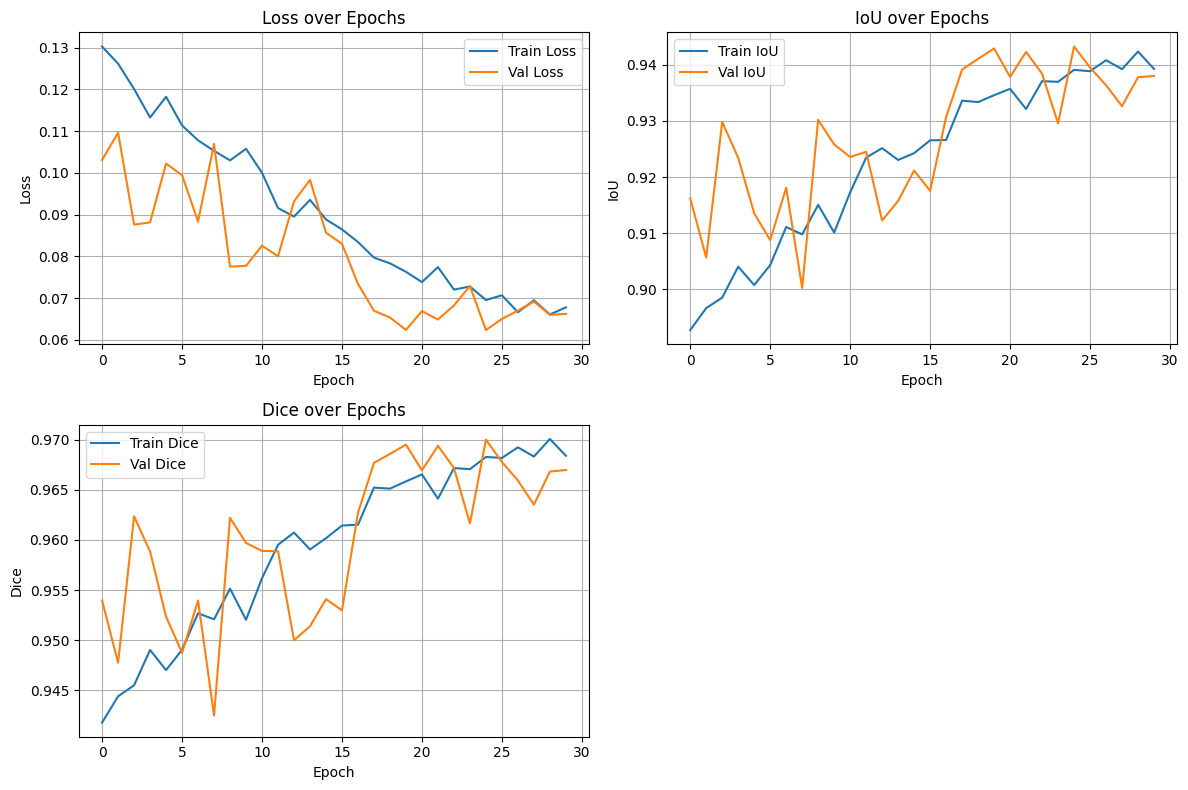

In [33]:
# Assuming you have lists to store the history like this in your training loop:
# train_losses = []
# val_losses = []
# train_ious = []
# val_ious = []
# train_dices = []
# val_dices = []

# Example plotting code (replace with your actual history lists)

plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(2, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.title('IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Plot Dice
plt.subplot(2, 2, 3)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.title('Dice over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

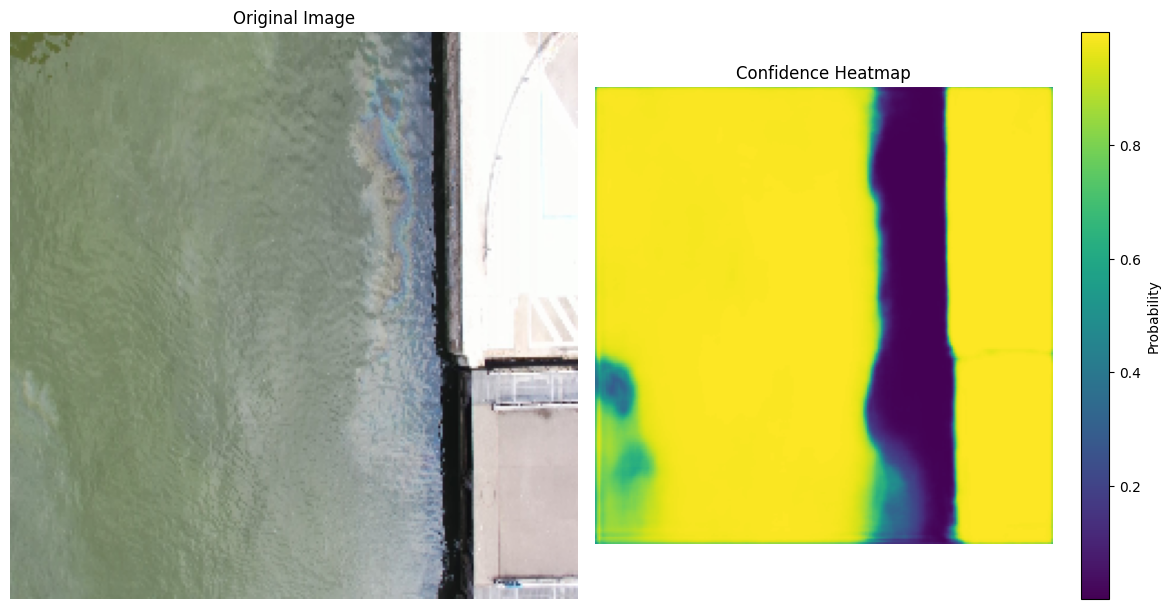

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming the model and DEVICE are already defined
# Load the best model (if not already loaded)
# model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
# model.eval() # Set model to evaluation mode

# Assuming val_loader is defined and accessible
# Get a batch from the validation loader
imgs, masks = next(iter(val_loader))

# Select the first image from the batch
img = imgs[0]

# Move image to device and add batch dimension for prediction
img_tensor = img.unsqueeze(0).to(DEVICE)

# Get raw logits from the model
with torch.no_grad():
    logits = model(img_tensor)
    # Apply sigmoid to get probabilities
    probability_map = torch.sigmoid(logits).squeeze().cpu().numpy()

# De-normalize the image for display if it was normalized during preprocessing
# Assuming normalization mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
img_display = img.permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1)


# Plotting the original image and the confidence heatmap
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_display)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(probability_map, cmap='viridis') # Using 'viridis' colormap for heatmap
plt.title("Confidence Heatmap")
plt.colorbar(label="Probability")
plt.axis("off")

plt.tight_layout()
plt.show()

In [34]:
# Save the content of the current cell to a file named app.py
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import cv2
import os # Import os for path joining

# Define DEVICE and model architecture (must match training)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMGSIZE = (256, 256) # Must match the size used during training

# Define the path to the saved model (ensure this path is correct)
# Assuming the model was saved in the same directory as the notebook
model_path = "best_model.pth"

# Check if the model file exists
if not os.path.exists(model_path):
    st.error(f"Model file not found at: {model_path}. Please ensure 'best_model.pth' is in the correct location.")
else:
    # Load the trained model
    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights=None, # No imagenet weights needed for inference
        in_channels=3,
        classes=1,
        activation=None
    ).to(DEVICE)

    # Load the state dict. Ensure the path is correct.
    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval() # Set model to evaluation mode
    except Exception as e:
        st.error(f"Error loading model state dictionary: {e}")
        model = None # Set model to None if loading fails


# Function to predict mask
def predict_mask(image, model, device, img_size):
    if model is None:
        return None # Return None if model failed to load

    # Preprocess the image
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR) # Convert PIL to OpenCV BGR
    image = cv2.resize(image, img_size) # Resize
    image = image / 255.0 # Normalize to [0, 1]

    # Apply the same normalization as training
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std

    image = np.transpose(image, (2, 0, 1)) # Change to CxHxW
    image = torch.from_numpy(image).float().unsqueeze(0).to(device) # To tensor and add batch dim

    with torch.no_grad():
        logits = model(image)
        pred_mask = torch.sigmoid(logits).squeeze().cpu().numpy() # Apply sigmoid and remove batch/channel dims

    # Apply a threshold (can be adjusted)
    threshold = 0.5
    binary_mask = (pred_mask > threshold).astype(np.uint8)

    return binary_mask

# Function to color the mask
def color_mask(mask):
    # mask: HxW, 1 or 0
    h, w = mask.shape
    cmask = np.zeros((h, w, 3), dtype=np.uint8)
    # Color oil spill area red
    cmask[mask==1] = [255, 0, 0]
    return cmask

# Streamlit app
st.title("Oil Spill Detection")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image.", use_column_width=True)

    if st.button("Predict Oil Spill"):
        if 'model' in locals() and model is not None:
            with st.spinner('Predicting...'):
                pred_mask = predict_mask(image, model, DEVICE, IMGSIZE)

            if pred_mask is not None:
                # Calculate predicted oil spill area (number of oil spill pixels)
                oil_spill_pixels = np.sum(pred_mask)
                total_pixels = pred_mask.size
                oil_spill_percentage = (oil_spill_pixels / total_pixels) * 100 if total_pixels > 0 else 0

                # Convert the predicted mask to a color mask for visualization
                colored_pred_mask = color_mask(pred_mask)

                # Display the predicted mask
                st.subheader("Predicted Oil Spill Mask")
                st.image(colored_pred_mask, caption="Predicted Mask.", use_column_width=True)

                # Provide information in separate alert messages
                st.subheader("Prediction Summary")
                st.info(f"Predicted oil spill area: Approximately {oil_spill_pixels} pixels ({oil_spill_percentage:.2f}% of the image).")

                if oil_spill_percentage > 10: # Example threshold for significant spill
                    st.warning("This indicates a significant potential oil spill. Immediate action and further investigation are recommended.")
                elif oil_spill_percentage > 1: # Example threshold for minor spill
                    st.info("This suggests a possible minor oil spill. Monitoring and further assessment are advised.")
                else:
                    st.success("This indicates a low probability of a significant oil spill in this area. Continued vigilance is always a good practice.")

            else:
                st.error("Prediction failed due to model loading issues.")
        else:
            st.error("Model not loaded. Please check the model file path and try again.")

Writing app.py


In [35]:
!pip install pyngrok -q

In [36]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 113.3 MB/s eta 0:00:00


In [38]:
!streamlit run app.py &>/dev/null&

from pyngrok import ngrok
import os
from google.colab import userdata

# Use the GOOGLE_API_KEY secret for ngrok authentication
# Make sure you have added NGROK_AUTH_TOKEN to the Colab secrets
# panel (under the 🔑 icon)
try:
    ngrok_auth_token = userdata.get('NGROK_AUTH_TOKEN')
    ngrok.set_auth_token(ngrok_auth_token)

    # Establish a tunnel to the Streamlit port 8501
    public_url = ngrok.connect('8501') # Modified to pass port as the first argument

    print(f"Streamlit app available at: {public_url}")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please make sure you have added your NGROK_AUTH_TOKEN to the Colab secrets panel (under the 🔑 icon).")

Streamlit app available at: NgrokTunnel: "https://semisubterranean-preppily-elmer.ngrok-free.dev" -> "http://localhost:8501"
